# Intro, Pandas and Counting features in satellite images using scikit-image

The example below shows accessing ArcGIS Data, working with Pandas and using scikit-image library to detect circular features in farms using center pivot irrigation in Saudi Arabia. It then counts and reports the number of farms. This is one of the ways in which libraries from the scientific Python ecosystem can be integrated with the ArcGIS platform.

It uses the Multispectral Landsat imagery available at ArcGIS Online.

**Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

```
conda install scipy
conda install matplotlib
conda install scikit-image
```

## Import the library and Connect



In [20]:
from arcgis.gis import GIS

In [37]:
#Connect anonymously (for Landsat)
#agol = GIS("https://www.arcgis.com")

#Connect as your arcgis online user (For Sentinel 2)
agol = GIS("https://www.arcgis.com",'username')

Enter password: ········


## Search for Content

Search for items, display item details
Display item contents


<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
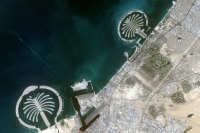

In [22]:
#Search for Landsat
#Sat = agol.content.search('"Multispectral Landsat"', 'Imagery Layer',outside_org=True)[0]
#Sat

#search for Sentinel 2
Sat = agol.content.search('"Sentinel-2 Views"', 'Imagery Layer',outside_org=True)[0]
Sat

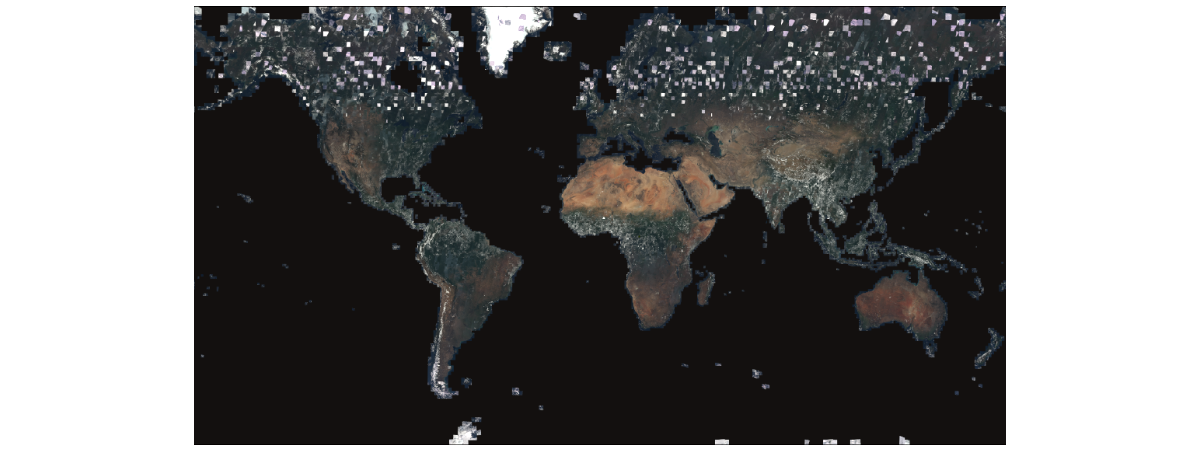

In [23]:
Satlyr = Sat.layers[0]
Satlyr

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
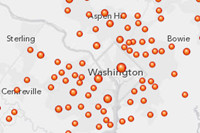

In [24]:
item = agol.content.get("85d0ca4ea1ca4b9abf0c51b9bd34de2e")
item

## Work with dataframes

In [25]:
import pandas as pd

In [26]:
sdf = pd.DataFrame.spatial.from_layer(item.layers[0])
sdf.head()

,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_5_9,AGE_65_74,AGE_75_84,...,PLACEFIPS,POP2010,POPULATION,POP_CLASS,RENTER_OCC,SHAPE,ST,STFIPS,VACANT,WHITE
0,2144,2314,2002,3531,3887,5643,6353,2067,5799,2850,...,0408220,39540,40346,6,6563,"{""x"": -12751215.004681978, ""y"": 4180278.406256...",AZ,04,6703,32367
1,876,867,574,1247,1560,2122,2342,733,2157,975,...,0424895,14364,14847,6,1397,"{""x"": -12755627.731115643, ""y"": 4164465.572856...",AZ,04,1389,12730
2,1000,1003,833,2311,2063,2374,3631,1068,6165,3776,...,0425030,26265,26977,6,1963,"{""x"": -12734674.294574209, ""y"": 3850472.723091...",AZ,04,9636,22995
3,2730,2850,2194,4674,5240,7438,8440,2499,8145,4608,...,0439370,52527,55041,7,6765,"{""x"": -12725332.21151233, ""y"": 4096532.0908223...",AZ,04,9159,47335
4,2732,2965,2024,3182,3512,3109,1632,2497,916,467,...,0463470,25505,29767,6,1681,"{""x"": -12770984.257542243, ""y"": 3826624.133935...",AZ,04,572,16120


In [27]:
m1 = GIS().map('United States')
m1

MapView(layout=Layout(height='400px', width='100%'))

In [28]:
sdf.spatial.plot(map_widget= m1)

True

The code below sets the extent of the layer, to a known extent of farms in Saudi Arabia and then visualizes the landsat layer: 

## Analyse Imagery

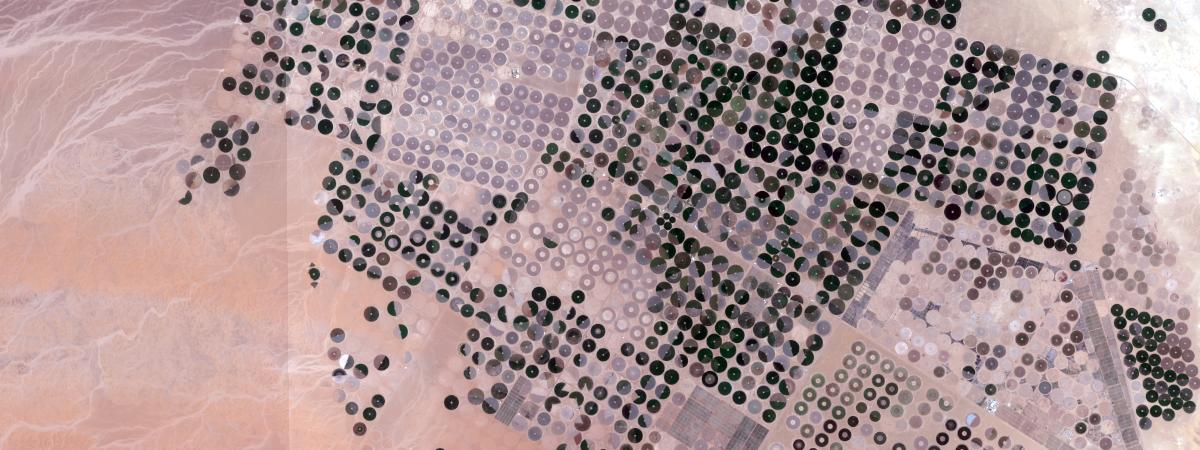

In [29]:
Satlyr.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                                         'type': 'extent',
                                         'xmax': 4296559.143733407,
                                         'xmin': 4219969.241391764,
                                         'ymax': 3522726.823081019,
                                         'ymin': 3492152.0117669892}
Satlyr

We can preprocess the imagery using raster functions. The code below uses the ndvi raster function to identify areas that have healthy vegetation. This preprocessing step makes the scikit-image blob detection algorithm work better.

In [30]:
from arcgis.raster.functions import ndvi, stretch

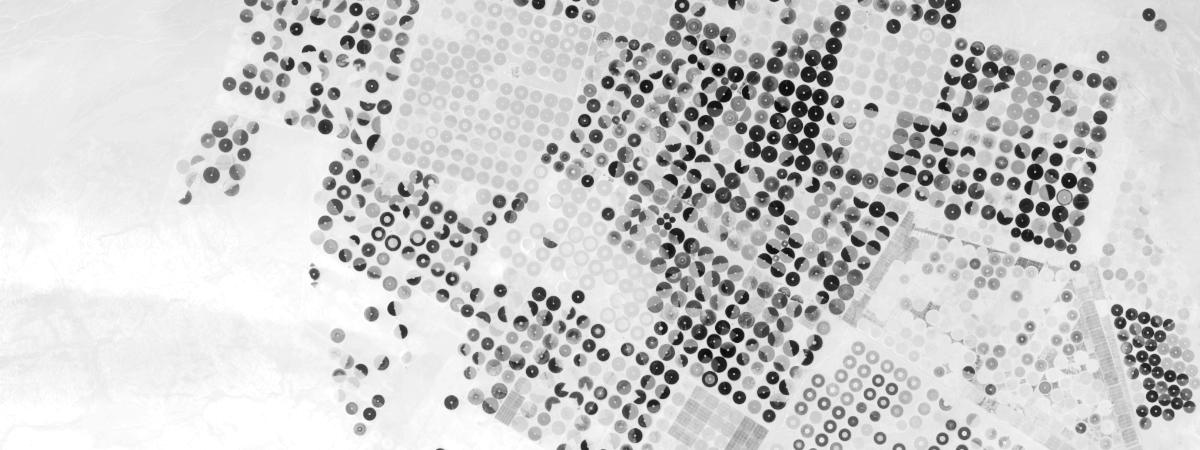

In [31]:
ndvi(Satlyr)

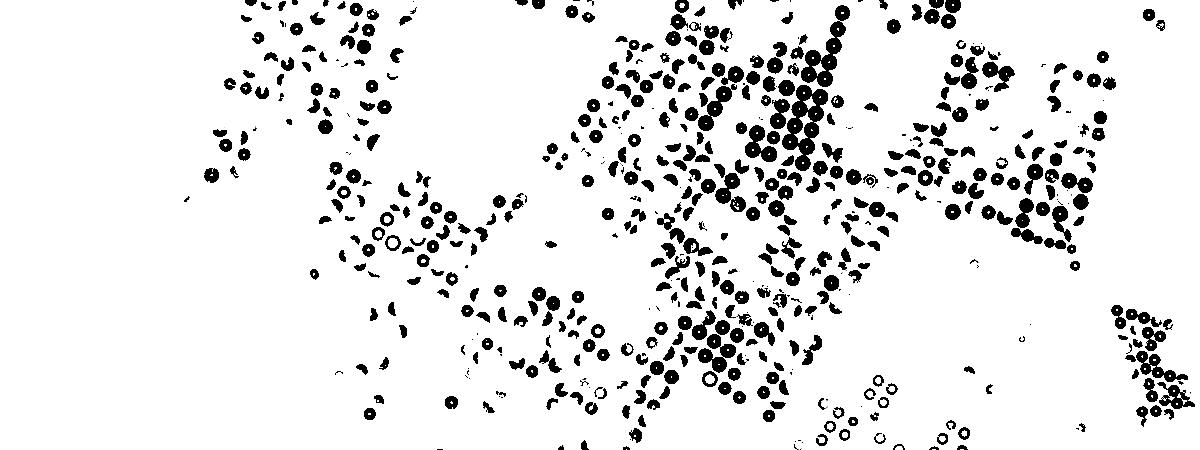

In [32]:
stretch(ndvi(Satlyr), stretch_type='PercentClip', min_percent=10, max_percent=90, dra=True)

The code below exports the imagery to a file from which we read it using matplotlib's image API and plot it:

In [33]:
img = stretch(ndvi(Satlyr), stretch_type='PercentClip', min_percent=10, max_percent=90, dra=True).export_image(bbox=Satlyr.extent, bbox_sr=102100, size=[1200, 450],
                       export_format='jpeg', save_folder='.', save_file='centerpivotfarms.jpg', f='image')

## Blob detection using scikit-image

The code below uses scikit-image library to find blobs in the given grayscale image, and reports the number of farms thus detected. It also plots them for visualization using matplotlib.

Blobs are found using the [Difference of Gaussian (DoG)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog) method.

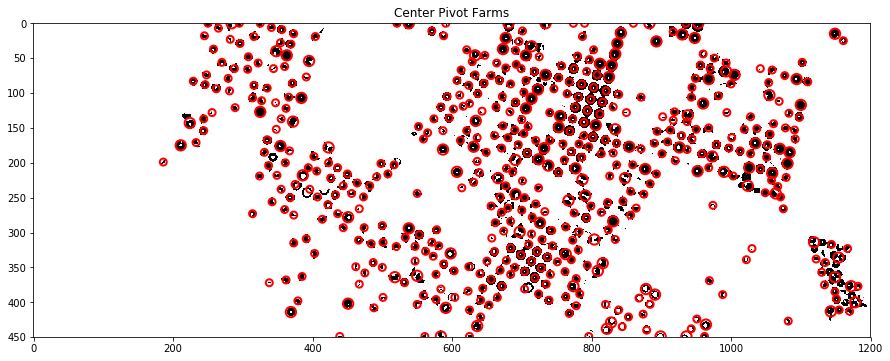

Number of center pivot farms detected: 518


In [34]:
from skimage import feature, color
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('centerpivotfarms.jpg')
bw = img.mean(axis=2)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)

blobs_dog = [(x[0],x[1],x[2]) for x in feature.blob_dog(-bw, 
                                                        min_sigma=4, 
                                                        max_sigma=8,
                                                        threshold=0.1,
                                                        overlap=0.6)]

#remove duplicates
blobs_dog = set(blobs_dog)

img_blobs = color.gray2rgb(img)

for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.imshow(img_blobs)
plt.title('Center Pivot Farms')

plt.show()
print('Number of center pivot farms detected: ' + str(len(blobs_dog)))